In [1]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import math

def rotSpring2DModIKModel(eleID, nodeR, nodeC, K, asPos, asNeg, MyPos, MyNeg, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN):
    """
    Creates a uniaxial material spring with deterioration using the Bilin material model
    and assigns it to a zero-length element.
    """

    # Create the Bilin uniaxial material with the given parameters
    ops.uniaxialMaterial('Bilin', eleID, K, asPos, asNeg, MyPos, MyNeg, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)

    # Create the zero-length element with the Bilin material in rotational direction (DOF 6)
    ops.element('zeroLength', eleID, nodeR, nodeC, '-mat', eleID, '-dir', 6)

    # Constrain the translational DOF with a multi-point constraint
    ops.equalDOF(nodeR, nodeC, 1, 2)

def rotLeaningCol(eleID, nodeR, nodeC):
    """
    Creates a zero-stiffness elastic rotational spring for the leaning column
    and constrains the translational DOFs of the spring.
    
    Parameters:
    eleID : int
        Unique element ID for this zero length rotational spring.
    nodeR : int
        Node ID which will be retained by the multi-point constraint.
    nodeC : int
        Node ID which will be constrained by the multi-point constraint.
    """
    
    # Spring Stiffness
    K = 1e-9  # k/in

    # Create the material and zero length element (spring)
    ops.uniaxialMaterial('Elastic', eleID, K)
    ops.element('zeroLength', eleID, nodeR, nodeC, '-mat', eleID, '-dir', 6)

    # Constrain the translational DOFs with a multi-point constraint
    ops.equalDOF(nodeR, nodeC, 1, 2)


In [2]:


# Units: kips, inches, seconds

# --------------------------------------------------------------------------------------------------
#          Set Up & Source Definition									  
# --------------------------------------------------------------------------------------------------

ops.wipe()
ops.model('Basic', '-ndm', 2, '-ndf', 3)

# Note: No equivalent of sourcing TCL scripts, these need to be defined in Python.

# --------------------------------------------------------------------------------------------------
#          Define Building Geometry, Nodes, and Constraints											  
# --------------------------------------------------------------------------------------------------

NStories = 2                # number of stories
NBays = 1                   # number of frame bays (excludes bay for P
WBay = 30.0 * 12.0          # bay width in inches
HStory1 = 15.0 * 12.0       # 1st story height in inches
HStoryTyp = 12.0 * 12.0     # story height of other stories in inches
HBuilding = HStory1 + (NStories - 1) * HStoryTyp   # height of building

# calculate locations of beam/column joints:
Pier1 = 0.0   # leftmost column line
Pier2 = Pier1 + WBay
Pier3 = Pier2 + WBay  # P-delta column line	
Floor1 = 0.0
Floor2 = Floor1 + HStory1
Floor3 = Floor2 + HStoryTyp

# calculate joint offset distance for beam plastic hinges
phlat23 = 0.0   # lateral dist from beam-col joint to loc of hinge on Floor 2

# calculate nodal masses -- lump floor masses at frame nodes
g = 386.2    # acceleration due to gravity
Floor2Weight = 535.0   # weight of Floor 2 in kips
Floor3Weight = 525.0   # weight of Floor 3 in kips
WBuilding = Floor2Weight + Floor3Weight   # total building weight
NodalMass2 = (Floor2Weight / g) / 2.0     # mass at each node on Floor 2
NodalMass3 = (Floor3Weight / g) / 2.0     # mass at each node on Floor 3
Negligible = 1e-9    # a very smnumber to avoid problems with zero

In [3]:
Pier1, Floor3

(0.0, 324.0)

Define Building Geometry, Nodes, and Constraints	

In [4]:
# Define nodes
# nodeID convention:  "xy" where x = Pier # and y = Floor # 
ops.node(11, Pier1, Floor1)
ops.node(21, Pier2, Floor1)
ops.node(31, Pier3, Floor1)
ops.node(12, Pier1, Floor2, '-mass', NodalMass2, Negligible, Negligible)
ops.node(22, Pier2, Floor2, '-mass', NodalMass2, Negligible, Negligible)
ops.node(32, Pier3, Floor2)
ops.node(13, Pier1, Floor3, '-mass', NodalMass3, Negligible, Negligible)
ops.node(23, Pier2, Floor3, '-mass', NodalMass3, Negligible, Negligible)
ops.node(33, Pier3, Floor3)

# Extra nodes for plastic hinge rotational springs
# nodeID convention:  "xya" where x = Pier #, y = Floor #, a = location relative to beam-column joint
# "a" convention: 2 = left; 3 = right;
# "a" convention: 6 = below; 7 = above; 
# column hinges at bottom of Story 1 (base)
ops.node(117, Pier1, Floor1)
ops.node(217, Pier2, Floor1)
# column hinges at top of Story 1
ops.node(126, Pier1, Floor2)
ops.node(226, Pier2, Floor2)
ops.node(326, Pier3, Floor2)  # zero-stiffness spring will be used on p-delta column
# column hinges at bottom of Story 2
ops.node(127, Pier1, Floor2)
ops.node(227, Pier2, Floor2)
ops.node(327, Pier3, Floor2)  # zero-stiffness spring will be used on p-delta column
# column hinges at top of Story 2
ops.node(136, Pier1, Floor3)
ops.node(236, Pier2, Floor3)
ops.node(336, Pier3, Floor3)  # zero-stiffness spring will be used on p-delta column

# beam hinges at Floor 2
ops.node(122, Pier1 + phlat23, Floor2)
ops.node(223, Pier2 - phlat23, Floor2)
ops.node(132, Pier1 + phlat23, Floor3)
ops.node(233, Pier2 - phlat23, Floor3)

# Constrain beam-column joints in a floor to have the same lateral displacement
# command: equalDOF $MasterNodeID $SlaveNodeID $dof1 $dof2.
dof1 = 1   # constrain movement in dof 1 (x-direction)
ops.equalDOF(12, 22, dof1)  # Floor 2:  Pier 1 to Pier 2
ops.equalDOF(12, 32, dof1)  # Floor 2:  Pier 1 to Pier 3
ops.equalDOF(13, 23, dof1)  # Floor 3:  Pier 1 to Pier 2
ops.equalDOF(13, 33, dof1)  # Floor 3:  Pier 1 to Pier 3

# Assign boundary conditions
# command:  fix nodeID dxFixity dyFixity rzFixity
# fixity values: 1 = constrained; 0 = unconstrained
# fix the base of the building; pin P-delta column at base
ops.fix(11, 1, 1, 1)
ops.fix(21, 1, 1, 1)
ops.fix(31, 1, 1, 0)  # P-delta column is pinned

Define Section Properties and Elements	

In [5]:
Es = 29000.0  # steel Young's modulus

# define column section W24x131 for Story 1 & 2
Acol_12 = 38.5     # cross-sectional area
Icol_12 = 4020.0   # moment of inertia
Mycol_12 = 20350.0  # yield moment

# determine stiffness modifications to equate the stiffness of the spring-elastic element-spring subassembly to the stiffness of the actual frame member
Abeam_23 = 30.0      # cross-sectional area (full section properties)
Ibeam_23 = 3620.0    # moment of inertia  (full section properties)
Mybeam_23 = 10938.0  # yield moment at plastic hinge location (i.e., My of RBS section, if used)
	# note: In this example the hinges form right at the beam-column joint, so using an RBS doesn't make sense; 
	#		however, it is done here simply for illustrative purposes.

# determine stiffness modifications to equate the stiffness of the spring-elastic element-spring subassembly to the stiffness of the actual frame member
	# Reference:  Ibarra, L. F., and Krawinkler, H. (2005). "Global collapse of frame structures under seismic excitations," Technical Report 152,
	#             The John A. Blume Earthquake Engineering Research Center, Department of Civil Engineering, Stanford University, Stanford, CA.
	# calculate modified section properties to account for spring stiffness being in series with the elastic element stiffness  
n = 10.0    # stiffness multiplier for rotational spring

# calculate modified moment of inertia for elastic elements
Icol_12mod = Icol_12 * (n + 1.0) / n     # modified moment of inertia for columns in Story 1 & 
Ibeam_23mod = Ibeam_23 * (n + 1.0) / n     # modified moment of inertia for beams in Floor 2 & 3

Ks_col_1 = n * 6.0 * Es * Icol_12mod / HStory1      # rotational stiffness of Story 1 column springs
Ks_col_2 = n * 6.0 * Es * Icol_12mod / HStoryTyp    # rotational stiffness of Story 2 column springs
Ks_beam_23 = n * 6.0 * Es * Ibeam_23mod / WBay      # rotational stiffness of Floor 2 & 3 beam springs

# set up geometric transformations of element
PDeltaTransf = 1
ops.geomTransf('PDelta', PDeltaTransf)

# Define elements
ops.element('elasticBeamColumn', 111, 117, 126, Acol_12, Es, Icol_12mod, PDeltaTransf)
ops.element('elasticBeamColumn', 121, 217, 226, Acol_12, Es, Icol_12mod, PDeltaTransf)
ops.element('elasticBeamColumn', 112, 127, 136, Acol_12, Es, Icol_12mod, PDeltaTransf)
ops.element('elasticBeamColumn', 122, 227, 236, Acol_12, Es, Icol_12mod, PDeltaTransf)

ops.element('elasticBeamColumn', 212, 122, 223, Abeam_23, Es, Ibeam_23mod, PDeltaTransf)
ops.element('elasticBeamColumn', 222, 132, 233, Abeam_23, Es, Ibeam_23mod, PDeltaTransf)

TrussMatID = 600 		# define a material ID  
Arigid = 1000.0			# define area of truss section (make much larger than A of frame elements)
Irigid = 100000.0		# moment of inertia for p-delta columns  (make much larger than I of frame elements)
ops.uniaxialMaterial('Elastic', TrussMatID, Es)   # define truss material

# rigid links
# command: element truss $eleID $iNode $jNode $A $materialID
ops.element('truss', 622, 22, 32, Arigid, TrussMatID)	# Floor 2
ops.element('truss', 623, 23, 33, Arigid, TrussMatID)	# Floor 3

# p-delta columns
# eleID convention:  7xy, 7 = p-delta columns, x = Pier #, y = Story #
ops.element('elasticBeamColumn', 731, 31, 326, Arigid, Es, Irigid, PDeltaTransf)	# Story 1
ops.element('elasticBeamColumn', 732, 327, 336, Arigid, Es, Irigid, PDeltaTransf)	# Story 2

Define Rotational Springs for Plastic Hinges

In [6]:
# define rotational spring properties and create spring elements using "rotSpring2DModIKModel" procedure
	# rotSpring2DModIKModel creates a uniaxial material spring with a bilinear response based on Modified Ibarra Krawinkler Deterioration Model
	# references provided in rotSpring2DModIKModel.tcl
	# input values for Story 1 column springs
McMy = 1.05         # ratio of capping moment to yield moment, Mc / My
LS = 1000.0         # basic strength deterioration (a very large # = no cyclic deterioration)
LK = 1000.0         # unloading stiffness deterioration (a very large # = no cyclic deterioration)
LA = 1000.0         # accelerated reloading stiffness deterioration (a very large # = no cyclic deterioration)
LD = 1000.0         # post-capping strength deterioration (a very large # = no deterioration)
cS = 1.0            # exponent for basic strength deterioration (c = 1.0 for no deterioration)
cK = 1.0            # exponent for unloading stiffness deterioration (c = 1.0 for no deterioration)
cA = 1.0            # exponent for accelerated reloading stiffness deterioration (c = 1.0 for no deterioration)
cD = 1.0            # exponent for post-capping strength deterioration (c = 1.0 for no deterioration)
th_pP = 0.025       # plastic rot capacity for pos loading
th_pN = 0.025       # plastic rot capacity for neg loading
th_pcP = 0.3        # post-capping rot capacity for pos loading
th_pcN = 0.3        # post-capping rot capacity for neg loading
ResP = 0.4          # residual strength ratio for pos loading
ResN = 0.4          # residual strength ratio for neg loading
th_uP = 0.4         # ultimate rot capacity for pos loading
th_uN = 0.4         # ultimate rot capacity for neg loading
DP = 1.0            # rate of cyclic deterioration for pos loading
DN = 1.0            # rate of cyclic deterioration for neg loading

# Define column springs using the rotSpring2DModIKModel function
a_mem = (n + 1.0) * (Mycol_12 * (McMy - 1.0)) / (Ks_col_1 * th_pP)   # strain hardening ratio of spring
b = a_mem / (1.0 + n * (1.0 - a_mem))    # modified strain hardening ratio of spring (Ibarra & Krawinkler 2005, note: Eqn B.5 is incorrect)

# Define column springs
	# Spring ID: "3xya", where 3 = col spring, x = Pier #, y = Story #, a = location in story
	# "a" convention: 1 = bottom of story, 2 = top of story
	# command: rotSpring2DModIKModel	id    ndR  ndC     K   asPos  asNeg  MyPos      MyNeg      LS    LK    LA    LD   cS   cK   cA   cD  th_p+   th_p-   th_pc+   th_pc-  Res+   Res-   th_u+   th_u-    D+     D-
	# col springs @ bottom of Story 1 (at base)
rotSpring2DModIKModel(3111, 11, 117, Ks_col_1, b, b, Mycol_12, -Mycol_12, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(3211, 21, 217, Ks_col_1, b, b, Mycol_12, -Mycol_12, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(3112, 12, 126, Ks_col_1, b, b, Mycol_12, -Mycol_12, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(3212, 22, 226, Ks_col_1, b, b, Mycol_12, -Mycol_12, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)

# recompute strain hardening since Story 2 is not the same height as Story 1
a_mem = (n + 1.0) * (Mycol_12 * (McMy - 1.0)) / (Ks_col_2 * th_pP)  # strain hardening ratio of spring
b = a_mem / (1.0 + n * (1.0 - a_mem))  # modified strain hardening ratio of spring (Ibarra & Krawinkler 2005, note: there is mistake in Eqn B.5)

rotSpring2DModIKModel(3121, 12, 127, Ks_col_2, b, b, Mycol_12, -Mycol_12, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(3221, 22, 227, Ks_col_2, b, b, Mycol_12, -Mycol_12, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(3122, 13, 136, Ks_col_2, b, b, Mycol_12, -Mycol_12, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(3222, 23, 236, Ks_col_2, b, b, Mycol_12, -Mycol_12, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)

Modified Ibarra-Medina-Krawinkler Model with Bilinear Hysteretic Response


In [7]:
# Define beam springs
    # Spring ID: "4xya", where 4 = beam spring, x = Bay #, y = Floor #, a = location in bay
    # "a" convention: 1 = left end, 2 = right end
    # redefine the rotations since they are not the same
th_pP = 0.02
th_pN = 0.02
th_pcP = 0.16
th_pcN = 0.16
a_mem = (n + 1.0) * (Mybeam_23 * (McMy - 1.0)) / (Ks_beam_23 * th_pP) # strain hardening ratio of spring
b = a_mem / (1.0 + n * (1.0 - a_mem))  # modified strain hardening ratio of spring (Ibarra & Krawinkler 2005, note: there is mistake in Eqn B.5)

rotSpring2DModIKModel(4121, 12, 122, Ks_beam_23, b, b, Mybeam_23, -Mybeam_23, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(4122, 22, 223, Ks_beam_23, b, b, Mybeam_23, -Mybeam_23, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(4131, 13, 132, Ks_beam_23, b, b, Mybeam_23, -Mybeam_23, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)
rotSpring2DModIKModel(4132, 23, 233, Ks_beam_23, b, b, Mybeam_23, -Mybeam_23, LS, LK, LA, LD, cS, cK, cA, cD, th_pP, th_pN, th_pcP, th_pcN, ResP, ResN, th_uP, th_uN, DP, DN)

# create region for beam springs
# region 2 -ele 4121 4122 4131 4132;


In [8]:
# Define p-delta column spring: zero-stiffness elastic spring	
	#Spring ID: "5xya" where 5 = leaning column spring, x = Pier #, y = Story #, a = location in story
	# "a" convention: 1 = bottom of story, 2 = top of story
	# rotLeaningCol ElemID ndR ndC 

# def rotLeaningCol(eleID, nodeR, nodeC):
#     # Create a zero-stiffness rotational spring
#     ops.uniaxialMaterial('Elastic', eleID, 1.0e-12)
#     ops.element('zeroLength', eleID, nodeR, nodeC, '-mat', eleID, '-dir', 6)
#     ops.equalDOF(nodeR, nodeC, 1, 2)

# create region for frame column springs
# command: region $regionID -ele $ele_1_ID $ele_2_ID...
# region 1 -ele 3111 3211 3112 3212 3121 3221 3122 3222;

rotLeaningCol(5312, 32, 326)
rotLeaningCol(5321, 32, 327)
rotLeaningCol(5322, 33, 336)

 Eigenvalue Analysis  

In [9]:
# Eigenvalue Analysis
pi = math.pi                        # Definition of pi
nEigenI = 1                          # mode i = 1
nEigenJ = 2                          # mode j = 2
lambdaN = ops.eigen(nEigenJ)         # eigenvalue analysis for nEigenJ modes
lambdaI = lambdaN[0]                # eigenvalue mode i = 1
lambdaJ = lambdaN[nEigenJ - 1]      # eigenvalue mode j = 2
w1 = math.sqrt(lambdaI)             # w1 (1st mode circular frequency)
w2 = math.sqrt(lambdaJ)             # w2 (2nd mode circular frequency)
T1 = 2.0 * pi / w1              # 1st mode period of the structure
T2 = 2.0 * pi / w2              # 2nd mode period of the structure
print(f"T1 = {T1} s")           # display the first mode period in the command window
print(f"T2 = {T2} s")           # display the second mode period in the command window

T1 = 0.8198074473990256 s
T2 = 0.20812628532312813 s


ProfileSPDLinDirectSolver::solve() -  aii < 0 (i, aii): (9, 0)


Gravity Loads & Gravity Analysis

In [10]:
# apply gravity loads
	#command: pattern PatternType $PatternID TimeSeriesType
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 101, 1)

# point loads on leaning column nodes
# command: load node Fx Fy Mz
P_PD2 = -398.02       # Floor 2
P_PD3 = -391.31       # Floor 3
ops.load(32, 0.0, P_PD2, 0.0)    # Floor 2
ops.load(33, 0.0, P_PD3, 0.0)    # Floor 3

# point loads on frame column nodes
P_F2 = 0.5 * (-1.0 * Floor2Weight - P_PD2)  # load on each frame node in Floor 2
P_F3 = 0.5 * (-1.0 * Floor3Weight - P_PD3)  # load on each frame node in Floor 3

# Floor 2 loads
ops.load(12, 0.0, P_F2, 0.0)
ops.load(22, 0.0, P_F2, 0.0)
# Floor 3 loads
ops.load(13, 0.0, P_F3, 0.0)
ops.load(23, 0.0, P_F3, 0.0)

Gravity-analysis: load-controlled static analysis

In [11]:
Tol = 1.0e-6                # convergence tolerance for test
ops.constraints('Plain')                # how it handles boundary conditions
ops.numberer('RCM')             # renumber dof's to minimize band-width (optimization)
ops.system('BandGeneral')               # how to store and solve the system of equations in the analysis (large model: try UmfPack)
ops.test('NormDispIncr', Tol, 6)
ops.algorithm('Newton')
NstepGravity = 10
DGravity = 1.0 / NstepGravity
ops.integrator('LoadControl', DGravity)
ops.analysis('Static')
ops.analyze(NstepGravity)

# maintain constant gravity loads and reset time to zero
ops.loadConst('-time', 0.0)
# print("Model Built")

In [12]:
# perform the analysis


# data = np.zeros((int(DGravity*NstepGravity+1), 2))
# for j in range(int(DGravity*NstepGravity)):
#     ops.analyze(1)
#     data[j+1,0] = ops.nodeDisp(12,1)
#     data[j+1,1] = ops.eleResponse(111,'forces')[1]

# plt.plot(data[:,0], data[:,1])
# plt.xlabel('Horizontal Displacement')
# plt.ylabel('Horizontal Load')
# plt.show()

In [13]:
# ops.eleResponse(111,'forces')

Pushover Analysis

In [14]:
# print("Running Pushover...")

lat2 = 16.255
lat3 = 31.636

ops.timeSeries('Linear', 2)
ops.pattern('Plain', 200, 2)
ops.load(12, lat2, 0.0, 0.0)
ops.load(22, lat2, 0.0, 0.0)
ops.load(13, lat3, 0.0, 0.0)
ops.load(23, lat3, 0.0, 0.0)

# ViewScale = 5
# Note: Display functions are not available in openseespy
IDctrlNode = 13
IDctrlDOF = 1
Dmax = 0.1 * HBuilding
Dincr = 0.01
# ops.constraints('Plain')
# ops.constraints('Transformation')
# ops.numberer('RCM')
# ops.system('BandGeneral')
# ops.test('NormUnbalance', 1.0e-6, 400)
ops.test('NormUnbalance', 1.0e-6, 400)
ops.algorithm('Newton')
ops.reactions()
ops.integrator('DisplacementControl', IDctrlNode, IDctrlDOF, Dincr)
# ops.analysis('Static')
Nsteps = int(Dmax / Dincr)
# ok = ops.analyze(Nsteps)

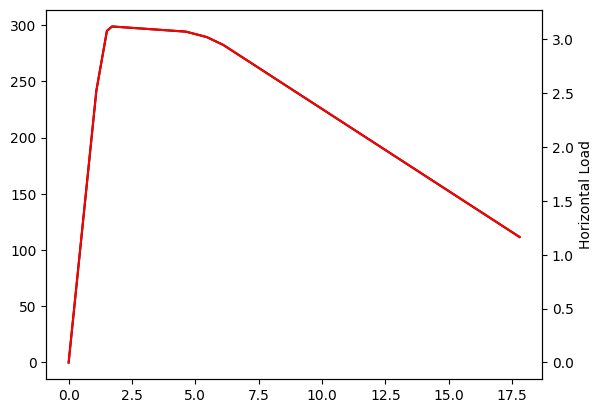

Pushover complete


In [15]:
data = np.zeros((int(Nsteps+1), 3))

for j in range(int(Nsteps)):
    ops.analyze(1)
    # data[j+1,0] = ops.nodeDisp(12,1)
    data[j+1,0] = ops.nodeDisp(12,1)

    # data[j+1,1] = ops.eleResponse(111,'forces')[3]
    data[j+1,1] = -(ops.eleResponse(111,'forces')[0]+ ops.eleResponse(121,'forces')[0]+ ops.eleResponse(731,'forces')[0])
    data[j+1,2] = ops.getLoadFactor(200)

    # data[j+1,1] = 

fig, ax1 = plt.subplots()

ax1.plot(data[:,0], data[:,1], color='k')
ax2 = ax1.twinx()
ax2.plot(data[:,0], data[:,2], color='red')
# plt.se
plt.xlabel('Horizontal Displacement')
plt.ylabel('Horizontal Load')
plt.show()

print("Pushover complete")

In [16]:
ops.getLoadFactor(200)

1.165151213386079

In [ ]:
ops.eleNodes(111)

In [ ]:
ops.eleResponse(111,'forces')[0], ops.eleResponse(121,'forces')[0], ops.eleResponse(731,'forces')[0]

In [ ]:
ops.eleResponse(111,'forces')[0]+ ops.eleResponse(121,'forces')[0]+ ops.eleResponse(731,'forces')[0]

In [ ]:
ops.nodeResponse(11,1,6), ops.nodeResponse(21,1,6), ops.nodeResponse(31,1,6)

In [ ]:
ops.nodeResponse(117,1,6), ops.nodeResponse(217,1,6), ops.nodeResponse(31,1,6)

In [ ]:
ops.eleResponse(3111,'forces')